In [1]:
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
import thinker
import thinker.viz_utils as viz
import thinker.util as util
import gym
import gym_sokoban
import os
import torch
from thinker.actor_net import sample, DRCNet
import pandas as pd

/home/tom/mlmi/dissertation/working_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-15 11:04:45,997	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.



Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


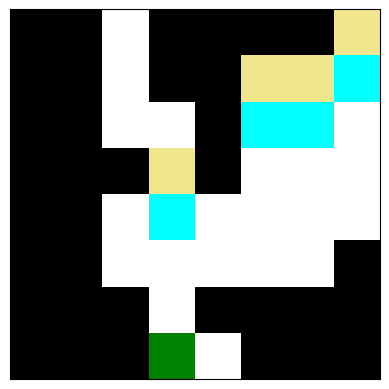

tensor([[[0.0113, 0.9598, 0.0120, 0.0087, 0.0082]]], grad_fn=<SelectBackward0>)

In [31]:
env_n = 1
gpu = False
mini_sokoban = True 
mini_unqtar = False
mini_unqbox = False

env = thinker.make(
    "Sokoban-cutoffpush_corrupt_0000-v0", 
    env_n=env_n, 
    gpu=gpu,
    wrapper_type=1, 
    has_model=False, 
    train_model=False, 
    parallel=False, 
    save_flags=False,
    mini=mini_sokoban,
    mini_unqtar=mini_unqtar,
    mini_unqbox=mini_unqbox         
    ) 
flags = util.create_setting(args=[], save_flags=False, wrapper_type=1) 
flags.mini = mini_sokoban
flags.mini_unqbtar = mini_unqtar
flags.mini_unqbox = mini_unqbox
drc_net = DRCNet(
    obs_space=env.observation_space,
    action_space=env.action_space,
    flags=flags,
    record_state=True,
    )
drc_net.to(env.device)

ckp_path = "../drc_mini"
ckp_path = os.path.join(util.full_path(ckp_path), "ckp_actor_realstep249000192.tar")
ckp = torch.load(ckp_path, env.device)
drc_net.load_state_dict(ckp["actor_net_state_dict"], strict=False)
rnn_state = drc_net.initial_state(batch_size=env_n, device=env.device)

# run the trained drc again
state = env.reset() 
env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False) # this converts the state to EnvOut object that can be processed by actor
actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)
state, reward, done, info = env.step(actor_out.action)
env_out = util.create_env_out(actor_out.action, state, reward, done, info, flags)
actor_out, new_rnn_state = drc_net(env_out, rnn_state, greedy=True)
viz.plot_mini_sokoban(state["real_states"][0])
actor_out.action_prob

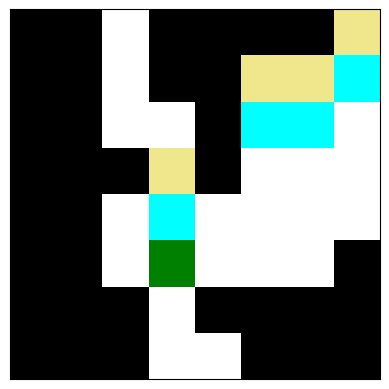

tensor([[[0.0117, 0.9528, 0.0092, 0.0138, 0.0125]]], grad_fn=<SelectBackward0>)

In [33]:
actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)
state, reward, done, info = env.step(actor_out.action)
env_out = util.create_env_out(actor_out.action, state, reward, done, info, flags)
viz.plot_mini_sokoban(state["real_states"][0])
actor_out.action_prob

In [9]:
class ActPatchDRCNet:

    def __init__(self, drc_net):
        self.drc_net = drc_net

    def forward_normal(self, env_out, rnn_state):
        return self.drc_net(env_out, rnn_state)
    
    def forward_patch(self, env_out, rnn_state, greedy=True, activ_type=None, patch_dict={}, activ_ticks=[], activs=None):
        
        activ_layers = list(patch_dict.keys())

        done = env_out.done
        T, B = done.shape
        x = self.drc_net.normalize(env_out.real_states.float())
        x = torch.flatten(x, 0, 1)
        x_enc = self.drc_net.encoder(x)
        core_input = x_enc.view(*((T, B) + x_enc.shape[1:]))

        record_state=self.drc_net.record_state

        assert len(core_input.shape) == 5
        core_output_list = []
        reset = done.float()
        if self.drc_net.record_state: 
            self.drc_net.core.hidden_state = []
            self.drc_net.core.hidden_state.append(torch.concat(rnn_state, dim=1)) 
        for n, (x_single, reset_single) in enumerate(
            zip(core_input.unbind(), reset.unbind())
        ):
            for t in range(self.drc_net.core.tran_t):
                if t > 0:
                    reset_single = torch.zeros_like(reset_single)
                reset_single = reset_single.view(-1)
                if t in activ_ticks and (0 in activ_layers or 1 in activ_layers or 2 in activ_layers):
                    #print(f"----- patching activations for tick {t} ---- ")
                    output, rnn_state = self.forward_single_patch(
                        x=x_single,
                        core_state=rnn_state,
                        reset=reset_single,
                        activ_type=activ_type, 
                        patch_dict=patch_dict,
                        activs=activs[:,t,:,:,:]
                    )  # output shape: 1, B, core_output_size
                else:
                    output, rnn_state = self.drc_net.core.forward_single(
                        x_single, rnn_state, reset_single, reset_single
                    )        
                if self.drc_net.record_state: self.drc_net.core.hidden_state.append(torch.concat(rnn_state, dim=1))      
            core_output_list.append(output)
        core_output = torch.cat(core_output_list)
        if self.drc_net.record_state: 
           self.drc_net.core.hidden_state = torch.stack(self.drc_net.core.hidden_state, dim=1)

        core_output = torch.flatten(core_output, 0, 1)

        if activ_type == "xenc" and 3 in activ_layers and 2 in activ_ticks:
            #print(f"--- Patching Layer 3 ---")
            #### activ_channels = [192+ c patch_dict[3]]
            patch_channels = patch_dict[3]
            x_enc[:,patch_channels,:,:] = activs[:,-1,[192+c for c in patch_channels],:,:]

        core_output = torch.cat([x_enc, core_output], dim=1)

        core_output = torch.flatten(core_output, 1)
        final_out = torch.nn.functional.relu(self.drc_net.final_layer(core_output))
        pri_logits = self.drc_net.policy(final_out)
        pri_logits = pri_logits.view(T*B, self.drc_net.dim_actions, self.drc_net.num_actions)
        pri_probs = torch.nn.functional.softmax(pri_logits.view(-1), dim=0)
        pri = sample(pri_logits, greedy=greedy, dim=-1)
        pri = pri.view(T, B, self.drc_net.dim_actions) 
        pri_env = pri[-1, :, 0] if not self.drc_net.tuple_action else pri[-1]   
        action = pri_env
        return action, pri_probs, pri_logits.view(-1), rnn_state
    
    def forward_single_patch(self, x, core_state, reset, activ_type=None, patch_dict={}, activs=None):
        reset = reset.float()

        activ_layers = list(patch_dict.keys())

        b, c, h, w = x.shape
        layer_n = 2
        out = core_state[(self.drc_net.core.num_layers - 1) * layer_n] * (1 - reset).view(
            b, 1, 1, 1
        )  # h_cur on last layer

        core_out = []
        new_core_state = []
        for n, cell in enumerate(self.drc_net.core.layers):
            cell_input = torch.concat([x, out], dim=1)
            h_cur = core_state[n * layer_n + 0] * (1 - reset.view(b, 1, 1, 1))
            c_cur = core_state[n * layer_n + 1] * (1 - reset.view(b, 1, 1, 1))
        
            if n in activ_layers and activ_type is not None:
                #print(f"--- Patching Layer {n} ---")
                patch_channels = patch_dict[n]
                if activ_type == "xenc":
                    patch_activs = activs[:,[192+c for c in patch_channels],:,:].detach().clone()
                elif activ_type == "hidden":
                    patch_activs = activs[:,[64*n+c for c in patch_channels],:,:].detach().clone()
                elif activ_type == "cell":
                    patch_activs = activs[:,[64*n+32+c for c in patch_channels],:,:].detach().clone()

                if activ_type == "xenc" and n in activ_layers:
                    #print(f"patching channels {patch_channels} in xenc")
                    cell_input[:,patch_channels,:,:] = patch_activs

                #print("out, x, cell_input:", out.sum(), x.sum(), cell_input.sum())

                h_next, c_next = self.forward_cell_patch(
                    convlstm_cell=cell,
                    input=cell_input,
                    h_cur=h_cur,
                    c_cur=c_cur,
                    activ_type=activ_type,
                    patch_channels=patch_channels, 
                    patch_activs=patch_activs
                )
            else:
                #print(f"--- NOT patching layer {n} ---")
                h_next, c_next, concat_k, concat_v = cell(
                    cell_input, h_cur, c_cur, None, None, None
                )
            if self.drc_net.core.grad_scale < 1 and h_next.requires_grad:
                h_next.register_hook(lambda grad: grad * self.drc_net.core.grad_scale)
                c_next.register_hook(lambda grad: grad * self.drc_net.core.grad_scale)
            new_core_state.append(h_next)
            new_core_state.append(c_next)
            out = h_next

        core_state = tuple(new_core_state)
        core_out = out.unsqueeze(0)
        return core_out, core_state
    
    def forward_cell_patch(self, convlstm_cell, input, h_cur, c_cur, activ_type=None, patch_channels=[], patch_activs=None):
        B = input.shape[0]
        #print("h_cur, c_cur, input", h_cur.sum(), c_cur.sum(), input.sum())
        combined = torch.cat([input, h_cur], dim=1)  # concatenate along channel axis
        if convlstm_cell.pool_inject:
            combined = torch.cat(
                [combined, convlstm_cell.proj_max_mean(h_cur)], dim=1
            )  # concatenate along channel axis
        if convlstm_cell.linear:
            combined_conv = convlstm_cell.main(combined[:, :, 0, 0]).unsqueeze(-1).unsqueeze(-1)
        else:
            combined_conv = convlstm_cell.main(combined)
        cc_i, cc_f, cc_o, cc_g, cc_a = torch.split(combined_conv, convlstm_cell.embed_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        c_next = f * c_cur + i * g
        #print("c_next:", c_next.sum())
        if activ_type=="cell":
            #print(f"patching channels {patch_channels} in cell")
            c_next[:,patch_channels,:,:] = patch_activs
        h_next = o * torch.tanh(c_next)
        if activ_type=="hidden":
            #print(f"patching channels {patch_channels} in hidden")
            h_next[:,patch_channels,:,:] = patch_activs
        #print(h_next.sum())

        return h_next, c_next

In [2]:
from actpatchdrc import ActPatchDRCNet

In [15]:
# interv
all_results = []
eval_metric = "prob"
exp = "cutoffpush"
mini_sokoban = True
mini_unqtar = False
mini_unqbox = False
gpu = False
env_n = 1
num_steps = 3
for i in range(16):
    results = {}
    flags = util.create_setting(args=[], save_flags=False, wrapper_type=1) 
    flags.mini = mini_sokoban
    flags.mini_unqbtar = mini_unqtar
    flags.mini_unqbox = mini_unqbox
    env = thinker.make(
        f"Sokoban-{exp}_clean_{i:04}-v0", 
        env_n=env_n, 
        gpu=gpu,
        wrapper_type=1, 
        has_model=False, 
        train_model=False, 
        parallel=False, 
        save_flags=False,
        mini=mini_sokoban,
        mini_unqtar=mini_unqtar,
        mini_unqbox=mini_unqbox         
    ) 

    drc_net = DRCNet(
        obs_space=env.observation_space,
        action_space=env.action_space,
        flags=flags,
        record_state=True,
        )
    drc_net.to(env.device)

    ckp_path = "../drc_mini"
    ckp_path = os.path.join(util.full_path(ckp_path), "ckp_actor_realstep249000192.tar")
    ckp = torch.load(ckp_path, env.device)
    drc_net.load_state_dict(ckp["actor_net_state_dict"], strict=False)
    test_net = ActPatchDRCNet(drc_net)

    clean_activs = []
    corrupt_activs = []
    clean_actions = []

    rnn_state = drc_net.initial_state(batch_size=env_n, device=env.device)
    state = env.reset()
    env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False)
    for step in range(num_steps):
        actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)
        clean_activs.append(drc_net.hidden_state[:,1:,:,:])
        #viz.plot_mini_sokoban(state["real_states"][0])
        state, reward, done, info = env.step(actor_out.action)
        clean_actions.append(actor_out.action)
        env_out = util.create_env_out(actor_out.action, state, reward, done, info, flags)

    #viz.plot_mini_sokoban(state["real_states"][0])    
    clean_loc = state["real_states"][0,[4,5],:,:].sum(dim=0).argmax()
    env_out = util.create_env_out(actor_out.action, state, reward, done, info, flags)
    actor_out, _ = drc_net(env_out, rnn_state, greedy=True)
    clean_activs.append(drc_net.hidden_state[:,1:,:,:])

    clean_probs = actor_out.action_prob.view(-1)
    clean_logits = actor_out.pri_param.view(-1).detach()
    clean_action_idx = actor_out.action_prob.view(-1).argmax().item()
    print("clean:", actor_out.action_prob.view(-1).tolist())

    env = thinker.make(
        f"Sokoban-{exp}_corrupt_{i:04}-v0", 
        env_n=env_n, 
        gpu=gpu,
        wrapper_type=1, 
        has_model=False, 
        train_model=False, 
        parallel=False, 
        save_flags=False,
        mini=mini_sokoban,
        mini_unqtar=mini_unqtar,
        mini_unqbox=mini_unqbox         
        ) 

    rnn_state = drc_net.initial_state(batch_size=env_n, device=env.device)
    state = env.reset()
    env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False)
    for step in range(num_steps):
        actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)
        corrupt_activs.append(drc_net.hidden_state[:,1:,:,:])
        #viz.plot_mini_sokoban(state["real_states"][0])
        state, reward, done, info = env.step(actor_out.action)
        env_out = util.create_env_out(actor_out.action, state, reward, done, info, flags)

    #viz.plot_mini_sokoban(state["real_states"][0])    
    corrupt_loc = state["real_states"][0,[4,5],:,:].sum(dim=0).argmax()
    env_out = util.create_env_out(actor_out.action, state, reward, done, info, flags)
    actor_out, _ = drc_net(env_out, rnn_state, greedy=True)
    corrupt_activs.append(drc_net.hidden_state[:,1:,:,:])

    corrupt_probs = actor_out.action_prob.view(-1)
    corrupt_logits = actor_out.pri_param.view(-1).detach()
    corrupt_action_idx = actor_out.action_prob.view(-1).argmax().item()
    print("corrupt:", actor_out.action_prob.view(-1).tolist())

    assert clean_loc == corrupt_loc, f"{clean_loc=},{corrupt_loc=}"

    if eval_metric == "ld":
        clean_ld = (clean_logits[clean_action_idx] - clean_logits[corrupt_action_idx]).item()
        corrupt_ld = (corrupt_logits[clean_action_idx] - corrupt_logits[corrupt_action_idx]).item()
        diff_ld = clean_ld - corrupt_ld
    elif eval_metric == "prob":
        corrupt_action_prob = corrupt_probs[clean_action_idx].item()

    mode = "cell"
    for layer in [0,1,2]:
        for c in [[20,16]]:
        #for c in [list(range(32))]:
            patch_dict = {layer: c}

            rnn_state = drc_net.initial_state(batch_size=env_n, device=env.device)
            state = env.reset() 
            env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False)
            
            for step in range(num_steps):
                patch_action, patch_action_probs, patch_logits, rnn_state = test_net.forward_patch(env_out, rnn_state, activ_type=mode, activ_ticks=[],
                                                                    patch_dict=patch_dict, activs=clean_activs[step])
                state, reward, done, info = env.step(patch_action)
                env_out = util.create_env_out(patch_action, state, reward, done, info, flags)

            patch_loc = state["real_states"][0,[4,5],:,:].sum(dim=0).argmax()
            assert patch_loc==clean_loc, f"{patch_loc=},{clean_loc=}"

            patch_action, patch_action_probs, patch_logits, _ = test_net.forward_patch(env_out, rnn_state, activ_type=mode, activ_ticks=[0,1],
                                                                patch_dict=patch_dict, activs=clean_activs[num_steps])
            
            if eval_metric == "ld":
                patch_ld = (patch_logits[clean_action_idx] - patch_logits[corrupt_action_idx]).item()
                patch_metric = (patch_ld - corrupt_ld) / diff_ld
            elif eval_metric == "prob": 
                patch_metric = patch_action_probs[clean_action_idx].item() - corrupt_action_prob

            #print("patch:", patch_action_probs.view(-1).tolist(), "metric: ", patch_metric)
            results[f"layer{layer}_{mode}_{c}"] = round(patch_metric,4)

    all_results.append(results)


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


clean: [0.008234323933720589, 0.005635156761854887, 0.0043194834142923355, 0.9769455194473267, 0.004865469876676798]
corrupt: [0.008973920717835426, 0.9691113829612732, 0.006021568551659584, 0.008533252403140068, 0.007359775248914957]


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


clean: [0.011133219115436077, 0.9689761996269226, 0.007548628840595484, 0.005681069102138281, 0.0066608889028429985]
corrupt: [0.00742545397952199, 0.006735776085406542, 0.007486819289624691, 0.0049478174187242985, 0.9734041094779968]


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


clean: [0.010836985893547535, 0.006020986940711737, 0.004456295631825924, 0.006134104449301958, 0.9725516438484192]
corrupt: [0.008922502398490906, 0.006932535674422979, 0.9682967066764832, 0.007956067100167274, 0.007892311550676823]


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


clean: [0.009504793211817741, 0.0065822056494653225, 0.9743398427963257, 0.004096832126379013, 0.005476233549416065]
corrupt: [0.0074764578603208065, 0.005434134509414434, 0.006897774990648031, 0.9737632274627686, 0.006428353954106569]


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


clean: [0.0092707434669137, 0.005745583213865757, 0.005578705109655857, 0.006626136600971222, 0.9727787971496582]
corrupt: [0.007109495345503092, 0.9773394465446472, 0.0052839783020317554, 0.004746792372316122, 0.005520206410437822]


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


clean: [0.011948324739933014, 0.00996183417737484, 0.960383951663971, 0.008581873029470444, 0.009124068543314934]
corrupt: [0.008336116559803486, 0.005344535689800978, 0.009758259169757366, 0.007924509234726429, 0.9686365723609924]


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


clean: [0.009909654967486858, 0.008772057481110096, 0.004675941541790962, 0.9693443179130554, 0.0072980173863470554]
corrupt: [0.006174164824187756, 0.0036624681670218706, 0.9820552468299866, 0.003887529717758298, 0.0042206523939967155]


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


clean: [0.01185438223183155, 0.9676253199577332, 0.00806732103228569, 0.0051588742062449455, 0.00729399872943759]


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


corrupt: [0.008512984029948711, 0.006370855495333672, 0.005398996639996767, 0.9725676774978638, 0.007149473298341036]


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


clean: [0.010190370492637157, 0.006555916275829077, 0.006333584431558847, 0.9704686999320984, 0.006451509892940521]


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


corrupt: [0.008491558954119682, 0.9699371457099915, 0.007964941672980785, 0.007286147214472294, 0.00632021389901638]


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


clean: [0.008744507096707821, 0.9772579073905945, 0.006981835700571537, 0.0033028707839548588, 0.003712874837219715]
corrupt: [0.007819700986146927, 0.005759280640631914, 0.009864658117294312, 0.005386981647461653, 0.9711694121360779]


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


clean: [0.012786075472831726, 0.010696450248360634, 0.0044001080095767975, 0.00923982448875904, 0.9628775119781494]
corrupt: [0.009437145665287971, 0.007477438077330589, 0.9695941805839539, 0.006753779016435146, 0.006737544666975737]


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


clean: [0.009566453285515308, 0.011243247427046299, 0.9704217314720154, 0.003958316054195166, 0.004810221027582884]
corrupt: [0.00675171846523881, 0.004800072871148586, 0.005542661063373089, 0.9774388670921326, 0.00546663161367178]


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


clean: [0.010819394141435623, 0.004898427054286003, 0.0064840167760849, 0.009953847154974937, 0.9678443670272827]
corrupt: [0.007032027933746576, 0.9774528741836548, 0.0063795363530516624, 0.004033856559544802, 0.0051017040386796]


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


clean: [0.01110102515667677, 0.007894366979598999, 0.966131329536438, 0.007246202323585749, 0.007627174258232117]
corrupt: [0.009361768141388893, 0.007593181915581226, 0.0107171181589365, 0.010142386890947819, 0.9621855616569519]


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


clean: [0.013928024098277092, 0.013931716792285442, 0.006828133948147297, 0.9478470087051392, 0.017465058714151382]
corrupt: [0.006182759068906307, 0.004507747013121843, 0.9802438020706177, 0.0032446293625980616, 0.0058210548013448715]


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


clean: [0.012295733205974102, 0.9592663645744324, 0.016326775774359703, 0.0052915881387889385, 0.0068194810301065445]
corrupt: [0.007788241375237703, 0.005669744685292244, 0.005492666736245155, 0.9752206206321716, 0.005828700494021177]


In [16]:
pd.DataFrame(all_results).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
"layer0_cell_[20, 16]",-0.0001,-0.0001,-0.0002,0.0002,0.0000,0.0001,0.0001,-0.0000,0.0005,0.0004,-0.0000,0.0001,-0.0000,0.0001,0.0000,0.0001
"layer1_cell_[20, 16]",-0.0003,-0.0015,-0.0008,-0.0003,-0.0001,-0.0013,-0.0001,0.0001,-0.0006,0.0002,-0.0007,-0.0000,-0.0002,-0.0018,0.0008,-0.0004
"layer2_cell_[20, 16]",0.7303,0.0027,-0.0001,0.0015,0.0704,0.0029,0.0001,0.0034,0.6798,0.0016,-0.0001,-0.0001,0.1629,0.0027,0.0002,0.0073


In [13]:
pd.DataFrame(all_results).T.mean(axis=1).sort_values()[-20:]

layer1_cell_[20, 16]   -0.000687
layer0_cell_[20, 16]    0.000044
layer2_cell_[20, 16]    0.223556
dtype: float64

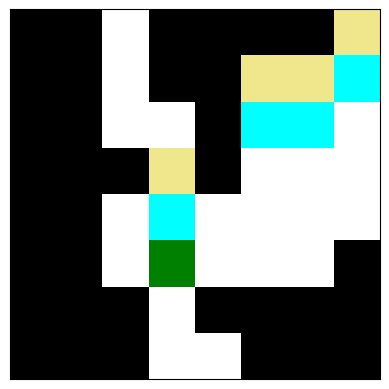

In [17]:
viz.plot_mini_sokoban(state["real_states"][0])

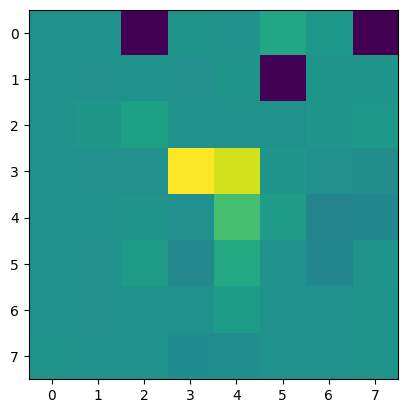

In [26]:
plt.imshow(clean_activs[3][0,1,64*2+32:192,:,:][20,:,:].detach(), vmin=-1, vmax=1)

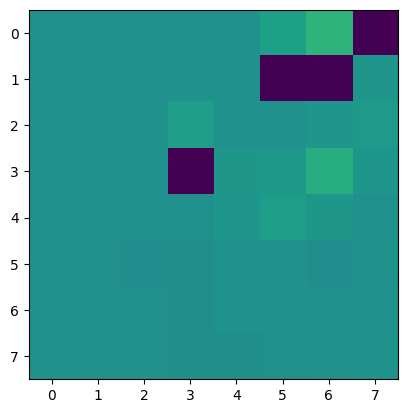

In [25]:
plt.imshow(corrupt_activs[3][0,1,64*2+32:192,:,:][20,:,:].detach(), vmin=-1, vmax=1)

In [82]:
pd.DataFrame(all_results).T.mean(axis=1).sort_values()[-20:]

layer0_cell_[29]   -0.000063
layer0_cell_[17]    0.000063
layer0_cell_[12]    0.000100
layer0_cell_[1]     0.000200
layer0_cell_[9]     0.000200
layer0_cell_[26]    0.000250
layer0_cell_[16]    0.000263
layer0_cell_[28]    0.000275
layer0_cell_[15]    0.000287
layer0_cell_[8]     0.000400
layer0_cell_[19]    0.000513
layer0_cell_[21]    0.000525
layer0_cell_[27]    0.000563
layer0_cell_[4]     0.000687
layer0_cell_[31]    0.000813
layer0_cell_[24]    0.000950
layer0_cell_[20]    0.001075
layer0_cell_[11]    0.001637
layer0_cell_[7]     0.002000
layer0_cell_[22]    0.010413
dtype: float64

In [79]:
pd.DataFrame(all_results).T.sort_values(by=3)

,0,1,2,3,4,5,6,7
layer1_cell_[22],-0.0005,0.0022,-0.0001,-0.0008,0.0013,0.0006,-0.0009,0.0016
layer1_cell_[20],-0.0008,-0.0006,-0.0008,-0.0006,0.0013,-0.0014,-0.0006,-0.0015
layer1_cell_[24],0.0030,-0.0008,0.0001,-0.0006,0.0007,0.0005,0.0003,0.0001
layer1_cell_[11],0.0003,-0.0010,0.0002,-0.0005,-0.0003,-0.0004,0.0001,-0.0008
layer1_cell_[16],-0.0002,-0.0031,-0.0001,-0.0004,0.0006,-0.0003,0.0011,-0.0003
layer1_cell_[7],0.0009,-0.0005,-0.0005,-0.0003,0.0013,0.0001,0.0023,-0.0014
layer1_cell_[17],-0.0002,-0.0014,0.0002,-0.0003,0.0000,0.0015,-0.0002,0.0006
layer1_cell_[14],0.0177,-0.0017,-0.0001,-0.0001,-0.0004,0.0022,0.0034,-0.0003
layer1_cell_[18],0.0015,-0.0007,-0.0002,-0.0001,-0.0007,-0.0008,0.0012,-0.0002
layer1_cell_[15],0.0019,-0.0000,0.0005,0.0000,0.0012,0.0005,0.0016,0.0000


In [69]:
pd.DataFrame(all_results).T.sort_values(by=3)[-20:]

,0,1,2,3,4,5,6,7
"layer2_cell_[3, 16, 20, 6, 8, 28, 15, 10, 16, 1]",0.8817,0.8805,0.8219,0.6762,0.9495,0.8145,0.4975,0.9347


In [72]:
pd.DataFrame(all_results).T.sort_values(by=3)[-20:]

,0,1,2,3,4,5,6,7
"layer2_cell_[3, 16, 20, 6, 8, 28, 15, 10, 16]",0.8213,0.8627,0.8272,0.605,0.9419,0.7663,0.1328,0.9165


In [56]:
pd.DataFrame(all_results).T

,0,1,2,3,4,5,6,7
"layer2_cell_[3, 16, 20, 6, 8, 28, 15, 1, 10, 16]",0.9609,0.9618,0.9529,0.9673,0.9483,0.9483,0.9784,0.8125


In [103]:
5e-1

0.5

In [356]:
for lab, res in results.items():
    if res > 0.01:
        print(lab, res)

In [296]:
state["real_states"][0,[4,5],:,:].sum(dim=0).argmax()

tensor(25)

In [304]:
env = thinker.make(
    "Sokoban-unsolvable_baseline_000-v0", 
    env_n=env_n, 
    gpu=gpu,
    wrapper_type=1, 
    has_model=False, 
    train_model=False, 
    parallel=False, 
    save_flags=False,
    mini=mini_sokoban,
    mini_unqtar=mini_unqtar,
    mini_unqbox=mini_unqbox         
    ) 
flags = util.create_setting(args=[], save_flags=False, wrapper_type=1) 
flags.mini = mini_sokoban
flags.mini_unqbtar = mini_unqtar
flags.mini_unqbox = mini_unqbox
drc_net = DRCNet(
    obs_space=env.observation_space,
    action_space=env.action_space,
    flags=flags,
    record_state=True,
    )
drc_net.to(env.device)

ckp_path = "../drc_mini"
ckp_path = os.path.join(util.full_path(ckp_path), "ckp_actor_realstep249000192.tar")
ckp = torch.load(ckp_path, env.device)
drc_net.load_state_dict(ckp["actor_net_state_dict"], strict=False)
env = thinker.make(
    f"Sokoban-unsolvable_baseline_000-v0", 
    env_n=env_n, 
    gpu=gpu,
    wrapper_type=1, 
    has_model=False, 
    train_model=False, 
    parallel=False, 
    save_flags=False,
    mini=mini_sokoban,
    mini_unqtar=mini_unqtar,
    mini_unqbox=mini_unqbox         
) 
rnn_state = drc_net.initial_state(batch_size=env_n, device=env.device)
state = env.reset()
#viz.plot_mini_sokoban(state["real_states"][0]) 
env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False)
actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)
state, reward, done, info = env.step(actor_out.action)
baseline_loc = state["real_states"][0,[4,5],:,:].sum(dim=0).argmax()
#viz.plot_mini_sokoban(state["real_states"][0])
env_out = util.create_env_out(actor_out.action, state, reward, done, info, flags)
actor_out, _ = drc_net(env_out, rnn_state, greedy=True)
results[f"base_probs"] = actor_out.action_prob.view(-1)

Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)
Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


In [310]:
actor_out.action_prob.view(-1).argmax()

tensor(1)

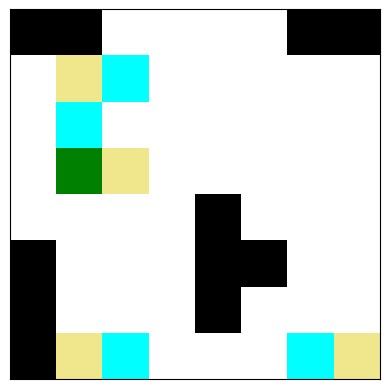

In [308]:
viz.plot_mini_sokoban(state["real_states"][0])

In [306]:
assert torch.all(baseline_loc == interv_loc)

In [283]:
# interv
env = thinker.make(
    f"Sokoban-unsolvable_baseline_000-v0", 
    env_n=env_n, 
    gpu=gpu,
    wrapper_type=1, 
    has_model=False, 
    train_model=False, 
    parallel=False, 
    save_flags=False,
    mini=mini_sokoban,
    mini_unqtar=mini_unqtar,
    mini_unqbox=mini_unqbox         
) 

drc_net = DRCNet(
    obs_space=env.observation_space,
    action_space=env.action_space,
    flags=flags,
    record_state=True,
    )
drc_net.to(env.device)
ckp_path = "../drc_mini"
ckp_path = os.path.join(util.full_path(ckp_path), "ckp_actor_realstep249000192.tar")
ckp = torch.load(ckp_path, env.device)
drc_net.load_state_dict(ckp["actor_net_state_dict"], strict=False)

patch_dict = {2:[16]}
rnn_state = drc_net.initial_state(batch_size=env_n, device=env.device)
state = env.reset() 
env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False)
#viz.plot_mini_sokoban(state["real_states"][0])
#print("===================Step 1=====================")
test_net = ActPatchDRCNet(drc_net)
action, action_probs, rnn_state = test_net.forward_patch(env_out, rnn_state, activ_type="cell", activ_ticks=[0,1,2],
                                                    patch_dict=patch_dict, activs=intervention_activs_1)
state, reward, done, info = env.step(action)#
#viz.plot_mini_sokoban(state["real_states"][0])
env_out = util.create_env_out(actor_out.action, state, reward, done, info, flags)
#print("===================Step 2=====================")
action, action_probs, _ = test_net.forward_patch(env_out, rnn_state, activ_type="cell", activ_ticks=[0,1],
                                                     patch_dict=patch_dict, activs=intervention_activs_2)
results["patch_probs"] = action_probs

results

Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


{'interv_probs': tensor([0.0158, 0.9393, 0.0129, 0.0052, 0.0267], grad_fn=<ViewBackward0>),
 'base_probs': tensor([0.0092, 0.0079, 0.0064, 0.9699, 0.0067], grad_fn=<ViewBackward0>),
 'patch_probs': tensor([0.0217, 0.8761, 0.0130, 0.0721, 0.0172], grad_fn=<SoftmaxBackward0>)}

In [190]:
intervention_activs_1[:,0,32:64,:,:].sum(), intervention_activs_1[:,0,:32,:,:].sum()

(tensor(-36.7094, grad_fn=<SumBackward0>),
 tensor(-21.0208, grad_fn=<SumBackward0>))

In [196]:
intervention_activs_1[:,0,2*64:2*64+32,:,:].sum()

tensor(8.2715, grad_fn=<SumBackward0>)

In [ ]:
h_cur = intervention_activs_1[:,0,:32,:,:]
c_cur = intervention_activs_1[:,0,32:64,:,:]
input = cell_input = torch.concat([x, out], dim=1)

In [ ]:
B = input.shape[0]
print("h_cur, c_cur, input", h_cur.sum(), c_cur.sum(), input.sum())
combined = torch.cat([input, h_cur], dim=1)  # concatenate along channel axis
if test_net.drc_net.core.layers[0].pool_inject:
    combined = torch.cat(
        [combined, test_net.drc_net.core.layers[0].proj_max_mean(h_cur)], dim=1
    )  # concatenate along channel axis
if test_net.drc_net.core.layers[0].linear:
    combined_conv = test_net.drc_net.core.layers[0].main(combined[:, :, 0, 0]).unsqueeze(-1).unsqueeze(-1)
else:
    combined_conv = test_net.drc_net.core.layers[0].main(combined)
cc_i, cc_f, cc_o, cc_g, cc_a = torch.split(combined_conv, test_net.drc_net.core.layers[0].embed_dim, dim=1)
i = torch.sigmoid(cc_i)
f = torch.sigmoid(cc_f)
o = torch.sigmoid(cc_o)
g = torch.tanh(cc_g)
c_next = f * c_cur + i * g
print("c_next:", c_next.sum())
print(h_next.sum())


In [182]:
# interv
env = thinker.make(
    f"Sokoban-unsolvable_baseline_000-v0", 
    env_n=env_n, 
    gpu=gpu,
    wrapper_type=1, 
    has_model=False, 
    train_model=False, 
    parallel=False, 
    save_flags=False,
    mini=mini_sokoban,
    mini_unqtar=mini_unqtar,
    mini_unqbox=mini_unqbox         
) 

drc_net = DRCNet(
    obs_space=env.observation_space,
    action_space=env.action_space,
    flags=flags,
    record_state=True,
    )
drc_net.to(env.device)
ckp_path = "../drc_mini"
ckp_path = os.path.join(util.full_path(ckp_path), "ckp_actor_realstep249000192.tar")
ckp = torch.load(ckp_path, env.device)
drc_net.load_state_dict(ckp["actor_net_state_dict"], strict=False)

patch_dict = {0:range(32)}
rnn_state = drc_net.initial_state(batch_size=env_n, device=env.device)
state = env.reset() 
env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False)
#viz.plot_mini_sokoban(state["real_states"][0])
print("===================Step 1=====================")
test_net = ActPatchDRCNet(drc_net)
action, action_probs, rnn_state = test_net.forward_patch(env_out, rnn_state, activ_type="hidden", activ_ticks=[0,1,2],
                                                    patch_dict=patch_dict, activs=intervention_activs_1)
state, reward, done, info = env.step(action)#
#viz.plot_mini_sokoban(state["real_states"][0])
env_out = util.create_env_out(actor_out.action, state, reward, done, info, flags)
print("===================Step 2=====================")
action, action_probs, _ = test_net.forward_patch(env_out, rnn_state, activ_type="hidden", activ_ticks=[0,1,2],
                                                     patch_dict=patch_dict, activs=intervention_activs_2)
results["patch_probs"] = action_probs

results

Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


===================Step 1=====================
----- patching activations for tick 0 ---- 
reset tensor(0.)
--- Patching Layer 0 ---
out, x, cell_input: tensor(0.) tensor(2.5460, grad_fn=<SumBackward0>) tensor(2.5460, grad_fn=<SumBackward0>)
h_cur, c_cur, input tensor(0.) tensor(0.) tensor(2.5460, grad_fn=<SumBackward0>)
patching channels range(0, 32) in hidden
tensor(-21.0208, grad_fn=<SumBackward0>)
--- NOT patching layer 1 ---
--- NOT patching layer 2 ---
----- patching activations for tick 1 ---- 
reset tensor(0.)
--- Patching Layer 0 ---
out, x, cell_input: tensor(7.8204, grad_fn=<SumBackward0>) tensor(2.5460, grad_fn=<SumBackward0>) tensor(10.3664, grad_fn=<SumBackward0>)
h_cur, c_cur, input tensor(-21.0208, grad_fn=<SumBackward0>) tensor(-33.1600, grad_fn=<SumBackward0>) tensor(10.3664, grad_fn=<SumBackward0>)
patching channels range(0, 32) in hidden
tensor(-50.8793, grad_fn=<SumBackward0>)
--- NOT patching layer 1 ---
--- NOT patching layer 2 ---
----- patching activations for 

{'interv_probs': tensor([0.0158, 0.9393, 0.0129, 0.0052, 0.0267], grad_fn=<ViewBackward0>),
 'base_probs': tensor([0.0092, 0.0079, 0.0064, 0.9699, 0.0067], grad_fn=<ViewBackward0>),
 'patch_probs': tensor([0.0476, 0.0080, 0.1361, 0.1486, 0.6597], grad_fn=<SoftmaxBackward0>)}

In [85]:
# hidden 0
results

{'interv_probs': tensor([0.0158, 0.9393, 0.0129, 0.0052, 0.0267], grad_fn=<ViewBackward0>),
 'base_probs': tensor([0.0092, 0.0079, 0.0064, 0.9699, 0.0067], grad_fn=<ViewBackward0>),
 'patch_probs': tensor([0.0298, 0.0070, 0.0459, 0.8133, 0.1039], grad_fn=<SoftmaxBackward0>)}

In [4]:
done = env_out.done
T, B = done.shape
x = drc_net.normalize(env_out.real_states.float())
x = torch.flatten(x, 0, 1)
x_enc = drc_net.encoder(x)
core_input = x_enc.view(*((T, B) + x_enc.shape[1:]))
core_output, rnn_state = drc_net.core(core_input, done, rnn_state, record_state=drc_net.record_state)

In [205]:
drc_net.core.attn

False

In [329]:
class ActPatchDRCNet:

    def __init__(self, drc_net):
        self.drc_net = drc_net

    def forward_normal(self, env_out, rnn_state):
        return self.drc_net(env_out, rnn_state)
    
    def forward_patch(self, env_out, rnn_state, greedy=True, activ_type=None, activ_channels=[], activ_layer=0, activ_ticks=[], activs=None):

        done = env_out.done
        T, B = done.shape
        x = self.drc_net.normalize(env_out.real_states.float())
        x = torch.flatten(x, 0, 1)
        x_enc = self.drc_net.encoder(x)
        core_input = x_enc.view(*((T, B) + x_enc.shape[1:]))

        record_state=self.drc_net.record_state

        assert len(core_input.shape) == 5
        core_output_list = []
        reset = done.float()
        if self.drc_net.record_state: 
            self.drc_net.core.hidden_state = []
            self.drc_net.core.hidden_state.append(torch.concat(rnn_state, dim=1)) 
        for n, (x_single, reset_single) in enumerate(
            zip(core_input.unbind(), reset.unbind())
        ):
            for t in range(self.drc_net.core.tran_t):
                if t > 0:
                    reset_single = torch.zeros_like(reset_single)
                reset_single = reset_single.view(-1)
                if t in activ_ticks:
                    output, rnn_state = self.forward_single_patch(
                        x=x_single,
                        core_state=rnn_state,
                        reset=reset_single,
                        activ_type=activ_type, 
                        activ_layer=activ_layer,
                        activ_channels=activ_channels,
                        activs=activs[:,t,:,:,:]
                    )  # output shape: 1, B, core_output_size
                else:
                    output, rnn_state = self.drc_net.core.forward_single(
                        x_single, rnn_state, reset_single, reset_single
                    )        
                if self.drc_net.record_state: self.drc_net.core.hidden_state.append(torch.concat(rnn_state, dim=1))      
            core_output_list.append(output)
        core_output = torch.cat(core_output_list)
        if self.drc_net.record_state: 
           self.drc_net.core.hidden_state = torch.stack(self.drc_net.core.hidden_state, dim=1)

        core_output = torch.flatten(core_output, 0, 1)
        core_output = torch.cat([x_enc, core_output], dim=1)

        if activ_type == "xenc":
            core_output[:,activ_channels,:,:] = activs[:activ_channels,:,:]

        core_output = torch.flatten(core_output, 1)
        final_out = torch.nn.functional.relu(self.drc_net.final_layer(core_output))
        pri_logits = self.drc_net.policy(final_out)
        pri_logits = pri_logits.view(T*B, self.drc_net.dim_actions, self.drc_net.num_actions)
        pri = sample(pri_logits, greedy=greedy, dim=-1)
        pri = pri.view(T, B, self.drc_net.dim_actions) 
        pri_env = pri[-1, :, 0] if not self.drc_net.tuple_action else pri[-1]   
        action = pri_env
        return action, pri_logits, rnn_state
    
    def forward_single_patch(self, x, core_state, reset, activ_type=None, activ_layer=None, activ_channels=[], activs=None):
        reset = reset.float()

        b, c, h, w = x.shape
        layer_n = 2
        out = core_state[(self.drc_net.core.num_layers - 1) * layer_n] * (1 - reset).view(
            b, 1, 1, 1
        )  # h_cur on last layer

        core_out = []
        new_core_state = []
        for n, cell in enumerate(self.drc_net.core.layers):
            cell_input = torch.concat([x, out], dim=1)
            h_cur = core_state[n * layer_n + 0] * (1 - reset.view(b, 1, 1, 1))
            c_cur = core_state[n * layer_n + 1] * (1 - reset.view(b, 1, 1, 1))
            if activ_type == "xenc":
                cell_input[:,activ_channels,:,:] = activs[:,activ_channels,:,:]
            if n == activ_layer and activ_type is not None:
                h_next, c_next = self.forward_cell_patch(
                    convlstm_cell=cell,
                    input=cell_input,
                    h_cur=h_cur,
                    c_cur=c_cur,
                    activ_type=activ_type, 
                    activ_channels=activ_channels, 
                    activs=activs
                )
            else:
                h_next, c_next, concat_k, concat_v = cell(
                    cell_input, h_cur, c_cur, None, None, None
                )
            if self.drc_net.core.grad_scale < 1 and h_next.requires_grad:
                h_next.register_hook(lambda grad: grad * self.drc_net.core.grad_scale)
                c_next.register_hook(lambda grad: grad * self.drc_net.core.grad_scale)
            new_core_state.append(h_next)
            new_core_state.append(c_next)
            out = h_next

        core_state = tuple(new_core_state)
        core_out = out.unsqueeze(0)
        return core_out, core_state
    
    def forward_cell_patch(self, convlstm_cell, input, h_cur, c_cur, activ_type=None, activ_channels=[], activs=None):
        B = input.shape[0]
        combined = torch.cat([input, h_cur], dim=1)  # concatenate along channel axis
        if convlstm_cell.pool_inject:
            combined = torch.cat(
                [combined, convlstm_cell.proj_max_mean(h_cur)], dim=1
            )  # concatenate along channel axis
        if convlstm_cell.linear:
            combined_conv = convlstm_cell.main(combined[:, :, 0, 0]).unsqueeze(-1).unsqueeze(-1)
        else:
            combined_conv = convlstm_cell.main(combined)
        cc_i, cc_f, cc_o, cc_g, cc_a = torch.split(combined_conv, convlstm_cell.embed_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        c_next = f * c_cur + i * g
        if activ_type=="cell":
            c_next[:,activ_channels,:,:] = activs[:,activ_channels,:,:]
        h_next = o * torch.tanh(c_next)
        if activ_type=="hidden":
            h_next[:,activ_channels,:,:] = activs[:,activ_channels,:,:]

        return h_next, c_next

In [646]:
env_n = 1
gpu = False
mini_sokoban = True 
mini_unqtar = False
mini_unqbox = False

env = thinker.make(
    "Sokoban-tom-v0", 
    env_n=env_n, 
    gpu=gpu,
    wrapper_type=1, 
    has_model=False, 
    train_model=False, 
    parallel=False, 
    save_flags=False,
    mini=mini_sokoban,
    mini_unqtar=mini_unqtar,
    mini_unqbox=mini_unqbox         
    ) 
flags = util.create_setting(args=[], save_flags=False, wrapper_type=1) 
flags.mini = mini_sokoban
flags.mini_unqbtar = mini_unqtar
flags.mini_unqbox = mini_unqbox
drc_net = DRCNet(
    obs_space=env.observation_space,
    action_space=env.action_space,
    flags=flags,
    record_state=True,
    )
drc_net.to(env.device)

ckp_path = "../drc_mini"
ckp_path = os.path.join(util.full_path(ckp_path), "ckp_actor_realstep249000192.tar")
ckp = torch.load(ckp_path, env.device)
drc_net.load_state_dict(ckp["actor_net_state_dict"], strict=False)

Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


mini=True, unqtar=False, unqbox=False
mini=True, unqtar=False, unqbox=False
mini=True, unqtar=False, unqbox=False


<All keys matched successfully>

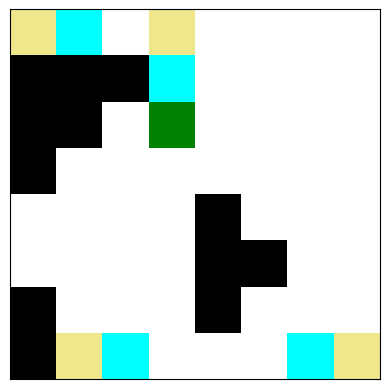

tensor([[[0.0128, 0.0048, 0.0060, 0.0085, 0.9679]]], grad_fn=<SelectBackward0>)

In [647]:
rnn_state = drc_net.initial_state(batch_size=env_n, device=env.device)
# run the trained drc again
state = env.reset() 
env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False) # this converts the state to EnvOut object that can be processed by actor
actor_out, rnn_state = drc_net(env_out, rnn_state)
state, reward, done, info = env.step(actor_out.action)
viz.plot_mini_sokoban(state["real_states"][0])
env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False) # this converts the state to EnvOut object that can be processed by actor
actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)
actor_out.action_prob

In [656]:
layer = 1
for i in range(32):
    channels = [i]
    test_net = ActPatchDRCNet(drc_net)
    action, logits, new_rnn_state = test_net.forward_patch(env_out, rnn_state, activ_type="cell", activ_ticks=[0,1,2,3], activ_channels=channels, activ_layer=layer, activs=nowall_states[:,:,64*layer+32:64*layer+64,:,:])
    print(i, torch.nn.functional.softmax(logits.view(-1), dim=0))

0 tensor([0.0132, 0.0057, 0.0071, 0.0098, 0.9642], grad_fn=<SoftmaxBackward0>)
1 tensor([0.0142, 0.0082, 0.0121, 0.0096, 0.9559], grad_fn=<SoftmaxBackward0>)
2 tensor([0.0160, 0.0091, 0.0119, 0.0117, 0.9513], grad_fn=<SoftmaxBackward0>)
3 tensor([0.0168, 0.0098, 0.0136, 0.0126, 0.9472], grad_fn=<SoftmaxBackward0>)
4 tensor([0.0148, 0.0054, 0.0125, 0.0125, 0.9548], grad_fn=<SoftmaxBackward0>)
5 tensor([0.0145, 0.0079, 0.0096, 0.0107, 0.9573], grad_fn=<SoftmaxBackward0>)
6 tensor([0.0158, 0.0090, 0.0114, 0.0120, 0.9518], grad_fn=<SoftmaxBackward0>)
7 tensor([0.0126, 0.0051, 0.0082, 0.0087, 0.9655], grad_fn=<SoftmaxBackward0>)
8 tensor([0.0151, 0.0079, 0.0110, 0.0110, 0.9550], grad_fn=<SoftmaxBackward0>)
9 tensor([0.0139, 0.0068, 0.0111, 0.0100, 0.9581], grad_fn=<SoftmaxBackward0>)
10 tensor([0.0185, 0.0109, 0.0173, 0.0157, 0.9376], grad_fn=<SoftmaxBackward0>)
11 tensor([0.0158, 0.0085, 0.0120, 0.0124, 0.9513], grad_fn=<SoftmaxBackward0>)
12 tensor([0.0145, 0.0066, 0.0122, 0.0081, 0.9586]

In [669]:
layer = 1
channels = range(32)
test_net = ActPatchDRCNet(drc_net)
action, logits, new_rnn_state = test_net.forward_patch(env_out, rnn_state, activ_type="cell", activ_ticks=[0,1,2,3], activ_channels=channels, activ_layer=layer, activs=nowall_states[:,:,64*layer+32:64*layer+64,:,:])
print(i, torch.nn.functional.softmax(logits.view(-1), dim=0))

31 tensor([0.0531, 0.6134, 0.0912, 0.0221, 0.2203], grad_fn=<SoftmaxBackward0>)


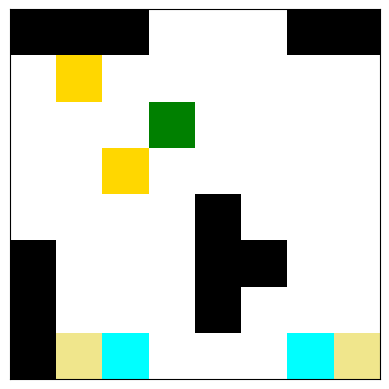

In [543]:
env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False) # this converts the state to EnvOut object that can be processed by actor
actor_out, rnn_state = drc_net(env_out, rnn_state)
state, reward, done, info = env.step(actor_out.action)
viz.plot_mini_sokoban(state["real_states"][0])

In [532]:
actor_out, rnn_state = drc_net(env_out, rnn_state)
actor_out.action_prob

tensor([[[0.0237, 0.8638, 0.0132, 0.0779, 0.0214]]], grad_fn=<SelectBackward0>)

In [555]:
rnn_state = drc_net.initial_state(batch_size=env_n, device=env.device)
# run the trained drc again
state = env.reset() 
env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False) # this converts the state to EnvOut object that can be processed by actor
#actor_out, rnn_state = drc_net(env_out, rnn_state)
layer = 2
channels = list(range(32))
test_net = ActPatchDRCNet(drc_net)
action, logits, rnn_state = test_net.forward_patch(env_out, rnn_state, activ_type="cell", activ_ticks=[0,1,2,3], activ_channels=channels, activ_layer=layer, activs=nowall_states[:,:,64*layer+32:64*layer+64,:,:])
print(torch.nn.functional.softmax(logits.view(-1), dim=0))

terminate called after throwing an instance of 'std::runtime_error'
  what():  box_left must be equal to 4 (room_id: 1)


EOFError: 

In [322]:
actor_out.action_prob

tensor([[[0.0548, 0.4744, 0.0477, 0.3799, 0.0432]]], grad_fn=<SelectBackward0>)

In [422]:
nowall_states = drc_net.hidden_state
nowall_states.shape

AttributeError: 'DRCNet' object has no attribute 'hidden_state'

Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


mini=True, unqtar=False, unqbox=False
mini=True, unqtar=False, unqbox=False
mini=True, unqtar=False, unqbox=False


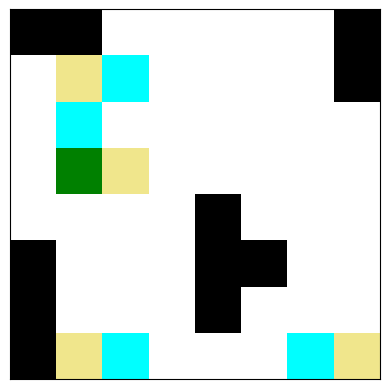

tensor([0.0561, 0.2003, 0.0643, 0.6668, 0.0125], grad_fn=<SoftmaxBackward0>)


/tmp/ipykernel_18617/2755026123.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(torch.nn.functional.softmax(logits.view(-1)))


In [418]:
env = thinker.make(
    "Sokoban-tom-v0", 
    env_n=env_n, 
    gpu=gpu,
    wrapper_type=1, 
    has_model=False, 
    train_model=False, 
    parallel=False, 
    save_flags=False,
    mini=mini_sokoban,
    mini_unqtar=mini_unqtar,
    mini_unqbox=mini_unqbox         
    ) 
rnn_state = drc_net.initial_state(batch_size=env_n, device=env.device)
# run the trained drc again
state = env.reset() 
env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False) # this converts the state to EnvOut object that can be processed by actor
#actor_out, rnn_state = drc_net(env_out, rnn_state)
layer = 2
channels = list(range(32))
test_net = ActPatchDRCNet(drc_net)
action, logits, rnn_state = test_net.forward_patch(env_out, rnn_state, activ_type="cell", activ_ticks=[0,1,2,3], activ_channels=channels, activ_layer=layer, activs=nowall_states[:,:,64*layer+32:64*layer+64,:,:])
viz.plot_mini_sokoban(state["real_states"][0])
state, reward, done, info = env.step(action)
env_out = util.create_env_out(action, state, reward, done, info, flags)
print(torch.nn.functional.softmax(logits.view(-1)))
#viz.plot_mini_sokoban(state["real_states"][0])

In [423]:
drc_net.hidden_state

AttributeError: 'DRCNet' object has no attribute 'hidden_state'

In [408]:
test_net = ActPatchDRCNet(drc_net)

tensor([0.0638, 0.4602, 0.1077, 0.3576, 0.0108], grad_fn=<SoftmaxBackward0>)


/tmp/ipykernel_18617/1211942467.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(torch.nn.functional.softmax(logits.view(-1)))


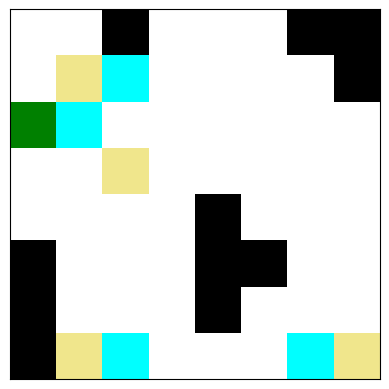

In [384]:
layer = 2
action, logits, rnn_state = test_net.forward_patch(env_out, rnn_state, activ_type="hidden", activ_ticks=[0,1,2,3], activ_channels=list(range(32)), activ_layer=layer, activs=nowall_states[:,:,64*layer:64*layer+32,:,:])
state, reward, done, info = env.step(action)
env_out = util.create_env_out(action, state, reward, done, info, flags)
print(torch.nn.functional.softmax(logits.view(-1)))
viz.plot_mini_sokoban(state["real_states"][0])

tensor([0.0096, 0.0104, 0.9656, 0.0062, 0.0081], grad_fn=<SoftmaxBackward0>)


/tmp/ipykernel_18617/2008896402.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(torch.nn.functional.softmax(logits.view(-1)))


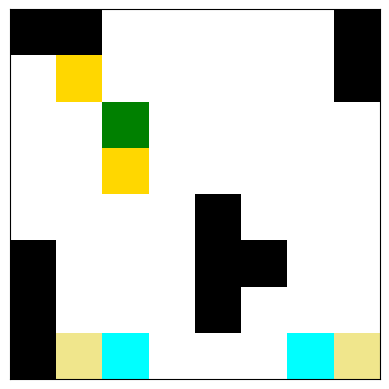

In [417]:
action, logits, rnn_state = test_net.forward_patch(env_out, rnn_state)
state, reward, done, info = env.step(action)
env_out = util.create_env_out(action, state, reward, done, info, flags)
print(torch.nn.functional.softmax(logits.view(-1)))
viz.plot_mini_sokoban(state["real_states"][0])

In [5]:
x = core_input
done = done
core_state = rnn_state
record_state=drc_net.record_state

assert len(x.shape) == 5
core_output_list = []
reset = done.float()
if record_state: 
    drc_net.core.hidden_state = []
    drc_net.core.hidden_state.append(torch.concat(core_state, dim=1)) 
for n, (x_single, reset_single) in enumerate(
    zip(x.unbind(), reset.unbind())
):
    for t in range(drc_net.core.tran_t):
        if t > 0:
            reset_single = torch.zeros_like(reset_single)
        reset_single = reset_single.view(-1)
        output, core_state = drc_net.core.forward_single(
            x_single, core_state, reset_single, reset_single
        )  # output shape: 1, B, core_output_size        
        if record_state: drc_net.core.hidden_state.append(torch.concat(core_state, dim=1))      
    core_output_list.append(output)
core_output = torch.cat(core_output_list)
if record_state: 
    drc_net.core.hidden_state = torch.stack(drc_net.core.hidden_state, dim=1)

core_output, rnn_state = core_output, core_state



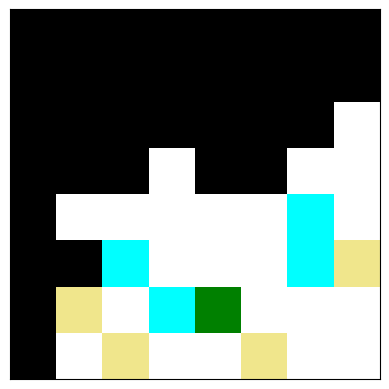

In [6]:
core_output = torch.flatten(core_output, 0, 1)
core_output = torch.cat([x_enc, core_output], dim=1)
core_output = torch.flatten(core_output, 1)
final_out = torch.nn.functional.relu(drc_net.final_layer(core_output))
pri_logits = drc_net.policy(final_out)
pri_logits = pri_logits.view(T*B, drc_net.dim_actions, drc_net.num_actions)
pri = sample(pri_logits, greedy=True, dim=-1)
pri = pri.view(T, B, drc_net.dim_actions) 
pri_env = pri[-1, :, 0] if not drc_net.tuple_action else pri[-1]   
action = pri_env 
state, reward, done, info = env.step(action)
env_out = util.create_env_out(action, state, reward, done, info, flags)
viz.plot_mini_sokoban(state["real_states"][0])